In [1]:
import sys
sys.path.insert(0, '/home/ashwin1996/FLD_optimal_weighting')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
from tfld import tfld, utils
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm, multivariate_normal, invwishart, wishart
from sklearn.metrics import balanced_accuracy_score as bas
from numpy.linalg import inv

from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# essential functions; from Ashwin's code
def generate_data(n, nu, d, cov, pi):
    "Draw data from the target distribution"
    n_1 = round(n*pi)
    n_0 = round(n*(1-pi))
    X_0 = np.random.multivariate_normal(-nu, cov, n_0)
    X_1 = np.random.multivariate_normal(nu, cov, n_1)
    X = np.concatenate((X_0, X_1), axis=0)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def create_dataset(n, nu, d, cov, pi=0.5, seed=None):
    "Draw data from the target distribution under a specified seed"
    if seed is not None:
        np.random.seed(seed)
    X, Y = generate_data(n, nu, d, cov, pi)
    return X, Y

def get_directions(d, J, k, seed=None):
    "Sample the target class 1 mean (nu^(0)) and J number of source projection vectors from a vMF distribution"
    mean_dir = np.zeros(d)
    mean_dir[0] = 1
    tfd = tfp.distributions
    vmf = tfd.VonMisesFisher(mean_direction=mean_dir, concentration=k)
        
    if seed is not None:
        tf.random.set_seed(seed)
        
    w = vmf.sample(J+1).numpy()    
    return w[0], w[1:]

def train_fld(X, y, cov, estimate_cov=True):
    "Train the FLD on the target data (return the learnt projection vector, covariance estimate, and target class 1 mean (nu^(0)) estimate"
    X_1 = X[y==1]
    X_0 = X[y==0]

    # estimate class means
    m_0 = np.mean(X_0, axis=0)
    m_1 = np.mean(X_1, axis=0)

    # estimate class covariance matrices
    if estimate_cov:
        n_0, n_1 = len(X_0), len(X_1)
        cov_0 = np.cov(X_0, rowvar=False)
        cov_1 = np.cov(X_1, rowvar=False)
        cov = ((n_0 - 1) * cov_0 + (n_1 - 1) * cov_1) / (n_0 + n_1 - 2) # pooled variance
    
    # estimate class priors
    p = len(y[y==1])/len(y)

    # estimate projection and threshold terms
    w_0 = np.linalg.pinv(2 * cov) @ (m_1 - m_0)
    w_0 /= np.linalg.norm(w_0, 2)
    c_0 = 2 * np.log((1-p)/p)
    nu_hat = (m_1 - m_0)/2

    return w_0, c_0, cov, nu_hat 

def compute_expected_risk(w_alpha, Sigma_t, nu):
    "Compute the expected accuracy of the combined hypothesis analytically"
    w_alpha = np.expand_dims(w_alpha, -1)
    nom = - w_alpha.T @ nu
    denom = np.sqrt(w_alpha.T @ Sigma_t @ w_alpha)
    risk = norm.cdf(nom / denom)
    return risk

def get_source_std_error(w_s):
    "Compute the estimated standard error of the average source projection vector"
    avg_ws = np.mean(w_s, axis=0)
    R = np.linalg.norm(avg_ws)
    avg_ws /= R
    J = len(w_s)
    d = 1 - np.mean((avg_ws @ w_s.T)**2)
    sigma = np.sqrt(d / (J * R**2))
    return sigma**2 * np.eye(w_s.shape[1])

def get_target_variance(n, mu, cov):
    mu = mu.reshape(len(mu), 1)
    inv_cov = np.linalg.inv(cov)
    cov_w = ((1 + mu.T @ inv_cov @ mu) * inv_cov - inv_cov @ mu @ mu.T @ inv_cov) / n
    # cov_w = inv_cov/n
    return cov_w
    
def get_covariance(d, seed=None):
    cov = wishart.rvs(10, np.eye(d), 1, random_state=seed)
    return cov

In [3]:
from sklearn.metrics import balanced_accuracy_score as bas

def experiment(n, d, J, k, cov=None, alpha_grid_size=0.1, estimate_cov=False):
    nu, source_projections = get_directions(d, J, k)
    combined_vector = tfld.estimate_mu(source_projections)
    variance_from_source = get_source_std_error(source_projections)
    
    cov = get_covariance(d)
    X, y = create_dataset(n, nu, d, cov)
    
    estimated_target_projection_vector, threshold, pooled_cov, class_1_mean = train_fld(X, y, cov=cov, estimate_cov=estimate_cov)    
    alpha_grid = np.arange(0, 1 + alpha_grid_size, step=alpha_grid_size)

    variance_from_target = get_target_variance(n, nu, cov)
    
    analytical_risks = np.zeros(len(alpha_grid))
    for i, alpha in enumerate(alpha_grid):
        true_projection_vector = np.linalg.inv(cov) @ nu
        true_projection_vector /= np.linalg.norm(true_projection_vector)
        
        w_alpha = alpha * true_projection_vector + (1-alpha) * combined_vector
        Sigma_alpha = alpha ** 2 * variance_from_target + (1-alpha)**2 * variance_from_source
        
        wa_samples = np.random.multivariate_normal(w_alpha, Sigma_alpha, 100)

        # compute expected risk per alpha analytically
        f = lambda wa_sample : compute_expected_risk(wa_sample, cov, nu)

        analytical_risks[i]  = np.mean(np.array(Parallel(n_jobs=-1)(delayed(f)(wa_sample) for wa_sample in wa_samples)))
        
    alpha_analytical = alpha_grid[np.argmin(analytical_risks)]
    
    X_test, y_test = create_dataset(100000, nu, d, cov)
    empirical_risks = np.zeros(len(alpha_grid))
    for i, alpha in enumerate(alpha_grid):
        temp_proj = alpha * estimated_target_projection_vector + (1 - alpha) * combined_vector
        t = X_test @ temp_proj

        preds = (t < 0).astype(int)
        empirical_risks[i] = bas(y_test, preds)
    
    alpha_empirical = alpha_grid[np.argmin(empirical_risks)]
        
    results = {}
    results['analytical_risks'] = [analytical_risks[0], analytical_risks[np.argmin(analytical_risks)], analytical_risks[-1]]
    results['empirical_risks'] = [empirical_risks[0], empirical_risks[np.argmin(empirical_risks)], empirical_risks[-1]]
    results['analytical_alpha'] = alpha_analytical
    results['empirical_alpha'] = alpha_empirical
    
    
    return results

In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm

d=10
J=100
k=10

n_list=[10, 20, 50, 100, 200, 500]
J_list = [10, 100, 1000]
n_mc = 1000

analytical_risks = np.zeros((n_mc, len(J_list), len(n_list), 3))
empirical_risks = np.zeros((n_mc, len(J_list), len(n_list), 3))
analytical_alphas = np.zeros((n_mc, len(J_list), len(n_list)))
empirical_alphas = np.zeros((n_mc, len(J_list), len(n_list)))

for ii, J in enumerate(J_list):
    for i, n in enumerate(tqdm(n_list)):
        f = lambda x: experiment(n, d, J, k, cov=None, estimate_cov=False)
        results = Parallel(n_jobs=-1)(delayed(f)(x) for x in np.zeros(n_mc))

        for j, result in enumerate(results):
            analytical_risks[j, ii,i] = result['analytical_risks']
            empirical_risks[j, ii,i] = result['empirical_risks']

            analytical_alphas[j, ii,i] = result['analytical_alpha']
            empirical_alphas[j, ii,i] = result['empirical_alpha']

 67%|██████▋   | 4/6 [07:21<03:40, 110.45s/it]Bad pipe message: %s [b't\xdcP\xc1d,\xa84_y\xa9\xa0\xa3\x1aQ\xd2;\x9d \x05\xc8\xc9\xdb\x840\x8cF\xf13el>\xb6\x9aE\xbd\x04t<\xdd\x08\xea\xa5i\x9e\xcc3\x87o\x05g\x00', b'\x02\x13\x03\x13\x01\x00\xff', b'']
Bad pipe message: %s [b"\xbbdD\x93V\xf4\x08\x04f0'\x9a\xf0\xd7\xf6\x99\x18q\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#"]
Bad pipe message: %s [b"\xaa\xf2\xdc\xd8T\x1f\x88K\x90\x03V\x8f\xdb\r\xf3\x12\x92v\x00\x00\xa6\xc0,\xc00\x0

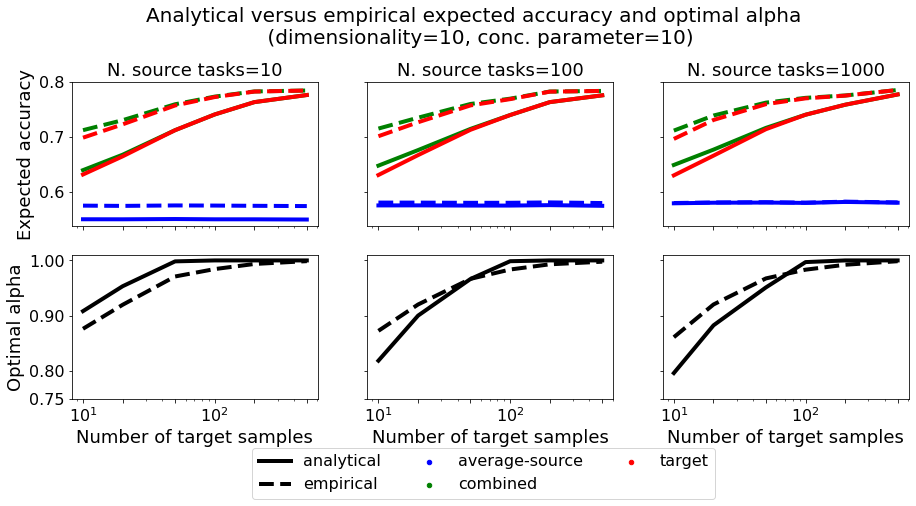

In [9]:
import matplotlib.pyplot as plt

mean_analytical_risks = np.mean(analytical_risks, axis=0)
mean_empirical_risks = np.mean(empirical_risks, axis=0)

algos = ['average-source', 'combined', 'target']
colors = ['b', 'g', 'r']


fig, ax = plt.subplots(2,3, figsize=(15,8), sharey='row', sharex=True)
for ii, J in enumerate(J_list):
    for i, algo in enumerate(algos):
        ax[0, ii].plot(n_list, 1- mean_analytical_risks[ii, :, i], color=colors[i], lw=4)
        ax[0, ii].plot(n_list, 1- mean_empirical_risks[ii, :, i], color=colors[i], ls='--', lw=4)
        ax[0, ii].set_title('N. source tasks=%i'%(J), fontsize=18)
        

mean_analytical_alphas = np.mean(analytical_alphas, axis=0)
mean_empirical_alphas = np.mean(empirical_alphas, axis=0) 
        
for ii, J in enumerate(J_list):
    ax[1, ii].plot(n_list, mean_analytical_alphas[ii], color='k', lw=4, label='analytical')
    ax[1, ii].plot(n_list, mean_empirical_alphas[ii], color='k', ls='--', lw=4, label='empirical')
    
xlim = ax[1,0].get_xlim()
ylim = ax[1,0].get_ylim()

for i, algo in enumerate(algos):
    ax[1,0].scatter(-1,-1, label=algos[i], color=colors[i], s=20)

ax[1,0].set_ylim(*ylim)
# ax[1,0].set_xlim(*xlim)
ax[1,0].set_xscale('log')


# - style ax0
ax[0,0].set_xticks(n_list)
ax[0,0].set_yticks([0.6, 0.7, 0.8])
ax[0,0].set_ylabel('Expected accuracy', fontsize=18)
ax[0,0].tick_params(labelsize=16)

#- style ax1

ax[1,0].set_yticks([0.75, 0.8, 0.9, 1])
ax[1,0].set_ylabel('Optimal alpha', fontsize=18)


for ax_ in ax[1]:
    ax_.set_xticks(n_list)
    ax_.tick_params(labelsize=16)
    ax_.set_xlabel('Number of target samples', fontsize=18)


fig.suptitle('Analytical versus empirical expected accuracy and optimal alpha \n (dimensionality=%i, conc. parameter=%i)'%(d, k), fontsize=20)

plt.subplots_adjust(bottom=0.3, top=0.85)
# ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

# ax[0,0].legend(fontsize=16, loc='center right')
ax[1,0].legend(fontsize=16, loc='lower left', ncol=3, bbox_to_anchor=(0.7, -0.75, 0.1, 0.2))

# plt.tight_layout()
# plt.savefig('analytical_versus_empirical.pdf')
plt.savefig("analytical_versus_empirical.pdf", bbox_inches="tight")